# Prototyping Notebook

This notebook aims to begin prototyping the IDS, implementing the DNN models, FL server and client logic, and incorporate PETs and XAI components.

## Phase 1 - Centralised DL


### Setup


In [ ]:
# general
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# DL
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

"""
# FL
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

# PETs
from opacus import PrivacyEngine

# XAI
import shap
import captum

NUM_CLIENTS = 10
BATCH_SIZE = 32
"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


c:\Users\Leo\ACS_Capstone\Code\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-02 21:13:43,876	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Data


(2219201, 63)
frame.time             object
ip.src_host            object
ip.dst_host            object
arp.dst.proto_ipv4     object
arp.opcode            float64
                       ...   
mbtcp.len             float64
mbtcp.trans_id        float64
mbtcp.unit_id         float64
Attack_label            int64
Attack_type            object
Length: 63, dtype: object
Attack_type
Normal                   1615643
DDoS_UDP                  121568
DDoS_ICMP                 116436
SQL_injection              51203
Password                   50153
Vulnerability_scanner      50110
DDoS_TCP                   50062
DDoS_HTTP                  49911
Uploading                  37634
Backdoor                   24862
Port_Scanning              22564
XSS                        15915
Ransomware                 10925
MITM                        1214
Fingerprinting              1001
Name: count, dtype: int64


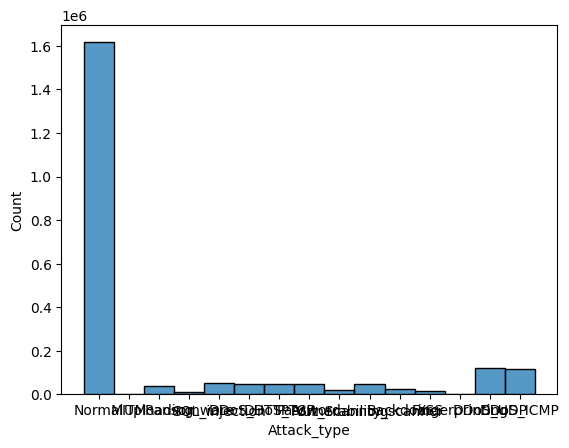

In [2]:
data_path = 'dataset/edge-iiotset/eval/DNN-EdgeIIoT-dataset.csv'

df = pd.read_csv(data_path, encoding='utf-8', low_memory=False)

print(df.shape)
print(df.dtypes)

print(df['Attack_type'].value_counts())

# plot histogram with value counts
sns.histplot(df['Attack_type'])
plt.show()


In [ ]:
# remove columns that are not useful
drop_columns = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4", "arp.dst.proto_ipv4",
                "http.file_data", "http.request.full_uri", "icmp.transmit_timestamp",
                "http.request.uri.query", "tcp.options", "tcp.payload", "tcp.srcport",
                "tcp.dstport", "udp.port", "mqtt.msg"]

df = df.drop(drop_columns, axis=1)

print(df.isna().any(axis=1).sum(), "rows with at least one NaN to remove")
print(df.isna().sum().sort_values(ascending=False))
df = df.dropna(axis=0, how='any')


In [5]:
print(df.duplicated().sum(), "fully duplicate rows to remove")
print(df.shape)
df.drop_duplicates(subset=None, keep="first", inplace=True)
print(df.shape)


309530 fully duplicate rows to remove
(2219201, 48)
(1909671, 48)


In [ ]:
# remove columns with high 0 values
zero_percent_columns = []

for col in df.columns:
    try:
        zero_ratio = (df[col] == 0).sum() / len(df)
        if zero_ratio >= 0.50:
            zero_percent_columns.append((col, zero_ratio))
            df.drop(col, axis=1, inplace=True)
    except:
        # skip non-numeric or problematic columns
        continue

# Display the results
for col, ratio in zero_percent_columns:
    print(f"{col}: {ratio:.2%} zeros")

print("number of dropped columns: ", len(zero_percent_columns))
print("New DF Shape: " , df.shape)


arp.opcode: 100.00% zeros
arp.hw.size: 100.00% zeros
icmp.checksum: 96.41% zeros
icmp.seq_le: 95.83% zeros
icmp.unused: 100.00% zeros
http.content_length: 97.68% zeros
http.response: 98.29% zeros
http.tls_port: 100.00% zeros
tcp.connection.fin: 89.91% zeros
tcp.connection.rst: 95.37% zeros
tcp.connection.syn: 93.85% zeros
tcp.connection.synack: 94.93% zeros
tcp.len: 65.83% zeros
udp.stream: 93.52% zeros
udp.time_delta: 99.87% zeros
dns.qry.name: 99.29% zeros
dns.qry.qu: 99.89% zeros
dns.qry.type: 100.00% zeros
dns.retransmission: 99.90% zeros
dns.retransmit_request: 100.00% zeros
dns.retransmit_request_in: 100.00% zeros
mqtt.conflag.cleansess: 95.65% zeros
mqtt.conflags: 95.65% zeros
mqtt.hdrflags: 82.61% zeros
mqtt.len: 86.96% zeros
mqtt.msg_decoded_as: 100.00% zeros
mqtt.msgtype: 82.61% zeros
mqtt.proto_len: 95.65% zeros
mqtt.topic_len: 95.65% zeros
mqtt.ver: 95.65% zeros
mbtcp.len: 99.99% zeros
mbtcp.trans_id: 99.99% zeros
mbtcp.unit_id: 99.99% zeros
Attack_label: 71.43% zeros
numbe

### Model

#### DNN


In [ ]:
class DNN(nn.Module):
    def __init__(self, input_dim=63, hidden_dim=128, output_dim=2):
        """
        Define model architecture here.\n
        
        Version 1: 03/07
        """
        super(DNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.15),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.15),
            
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)


#### CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_dim=63, hidden_dim=128, output_dim=2):
        """
        Define model architecture here.
        
        Version 1: 03/07
        """
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.15),
            
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.15),
            
            nn.Flatten(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)
